# Bifurcaciones con los parámetros $\tilde{Q}$ y $P_s$

**Nota:** Puede tardar unos minutos en terminar de ejecutar todo

Los parámetros fueron modificados respecto a los que aparecen en el paper original

In [1]:
from model import *
from scipy.signal import find_peaks

In [2]:
m = {'1': 0.125, '3': 0.005} # g
d = {'1': 0.25, '2': 0.05, '3': 0.01} # cm
r = {'1': 0.01, '2': 0.005, '3': 0.005} # g/ms
k = {'1': 0.08, '3': 0.01, '1,2': 0.05, '2,3': 0.01} # g/ms^2
c = {'1': 3 * k['1'], '3': 3 * k['3']} # g/ms^2
a0 = {'1': 0.01, '2': 0.01, '3': 0.01} # cm^2
l = 1.4 # cm
rho = 0.00113 # g/cm^3
k20 = 0.08 # g/ms^2
m20 = 0.025 # g

In [3]:
y0 = [0.1, 0.1, 0.1, 0, 0, 0]
rate = 20000
t = np.linspace(0, 1000, rate + 1)

In [4]:
def get_bifurcation_values(Q_values, Ps_values, init, Q_max, l_max_list, Q_min, l_min_list):
    total = {'x$_1$': [], 'x$_2$': [], 'x$_3$': [], 'U': []}
    
    for time in range(len(Q_values)):
        Q = Q_values[time]
        Ps = Ps_values[time]
        k['2'] = Q * k20
        c['2'] = 3 * k['2']
        m['2'] = m20

        sol = odeint(model, init, t, args=(m, d, r, k, c, a0, l, Ps))
        x1, x2, x3 = sol[:, 0], sol[:, 1], sol[:, 2]

        a1 = a0['1'] + 2 * l * x1
        a2 = a0['2'] + 2 * l * x2
        a3 = a0['3'] + 2 * l * x3

        a_min = np.asarray([a1, a2, a3]).min(0)
        U = np.sqrt((2 * Ps) / rho) * a_min * np.vectorize(theta)(a_min)
        
        signals = {'x$_1$': x1, 'x$_2$': x2, 'x$_3$': x3, 'U': U}
        
        for name, signal in signals.items():
            # Calculo los últimos 20 máximos locales
            peaks_max, _ = find_peaks(signal)
            l_max = signal[peaks_max][-20:]
            Q_max[name] += [time] * l_max.size
            l_max_list[name] += list(l_max)
            
            # Calculo los últimos 20 mínimos locales
            peaks_min, _ = find_peaks(-1 * signal)
            l_min = signal[peaks_min][-20:]
            Q_min[name] += [time] * l_min.size
            l_min_list[name] += list(l_min)
            
            # Agrego la señal al total
            total[name] += list(signal[-8192:] - signal[-8192:].mean())
        
        init = sol[-1,:]
    return total

In [5]:
Q_max = {'x$_1$': [], 'x$_2$': [], 'x$_3$': [], 'U': []}
local_max = {'x$_1$': [], 'x$_2$': [], 'x$_3$': [], 'U': []}
Q_min = {'x$_1$': [], 'x$_2$': [], 'x$_3$': [], 'U': []}
local_min = {'x$_1$': [], 'x$_2$': [], 'x$_3$': [], 'U': []}
Q_values = np.linspace(1, 0.3, 50)
Ps_values = np.linspace(0.015, 0.04, 50)
Q_values = np.concatenate((Q_values, Q_values[-2::-1]))
Ps_values = np.concatenate((Ps_values, Ps_values[-2::-1]))

total = get_bifurcation_values(Q_values, Ps_values, y0, Q_max, local_max, Q_min, local_min)

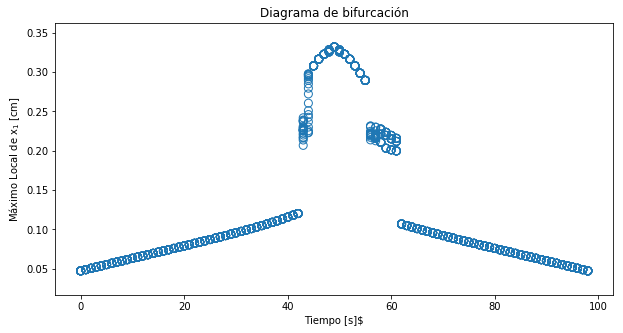

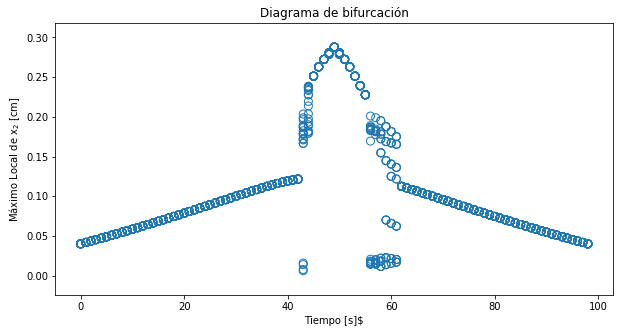

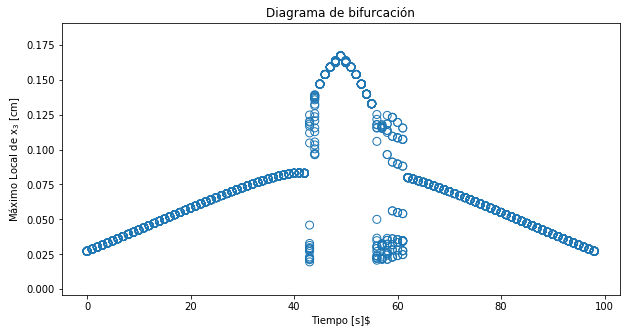

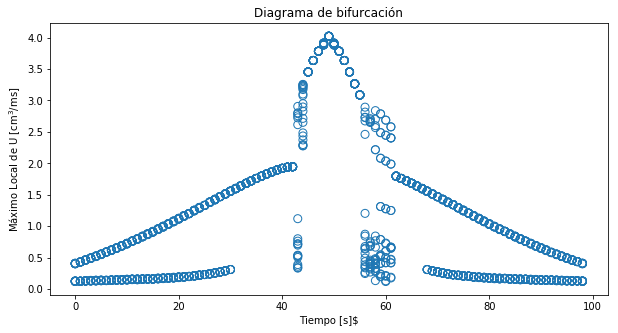

In [6]:
for name in Q_max:
    plt.figure(figsize=(10,5))
    plt.title('Diagrama de bifurcación')
    plt.xlabel('Tiempo [s]$')
    plt.ylabel('Máximo Local de {} [{}]'.format(name, 'cm' if name != 'U' else 'cm$^3$/ms'))
    plt.scatter(Q_max[name], local_max[name], facecolors='none', edgecolors='C0', s=64)
    plt.show()

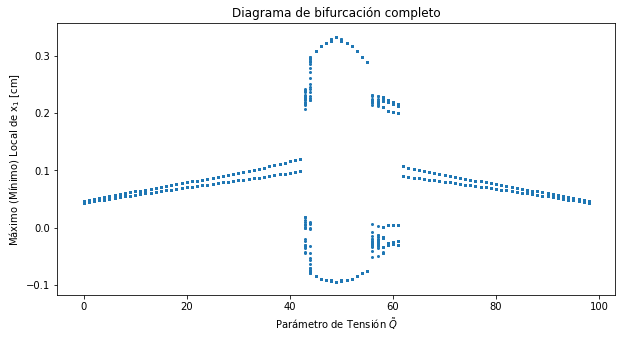

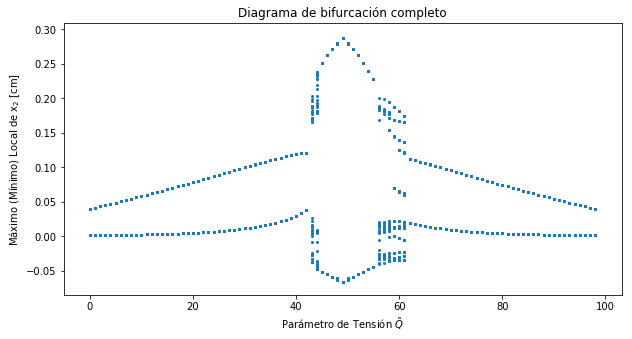

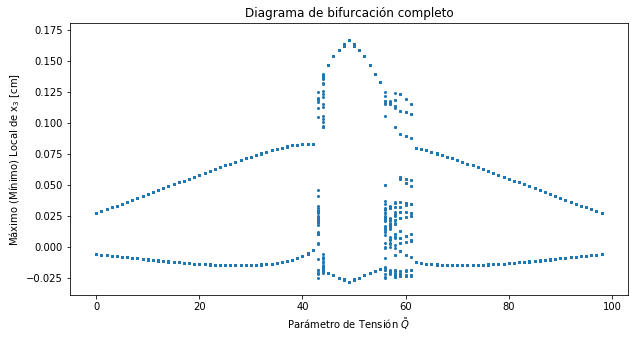

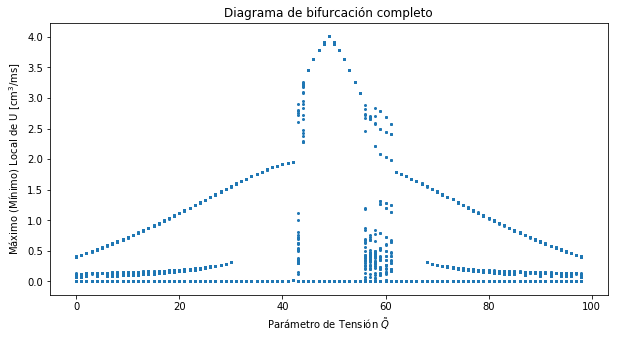

In [7]:
for name in Q_max:
    plt.figure(figsize=(10,5))
    plt.title('Diagrama de bifurcación completo')
    plt.xlabel(r'Parámetro de Tensión $\tilde{Q}$')
    plt.ylabel('Máximo (Mínimo) Local de {} [{}]'.format(name, 'cm' if name != 'U' else 'cm$^3$/ms'))
    plt.scatter(Q_max[name], local_max[name], marker='.', s=16)
    plt.scatter(Q_min[name], local_min[name], marker='.', color='C0', s=16)
    plt.show()

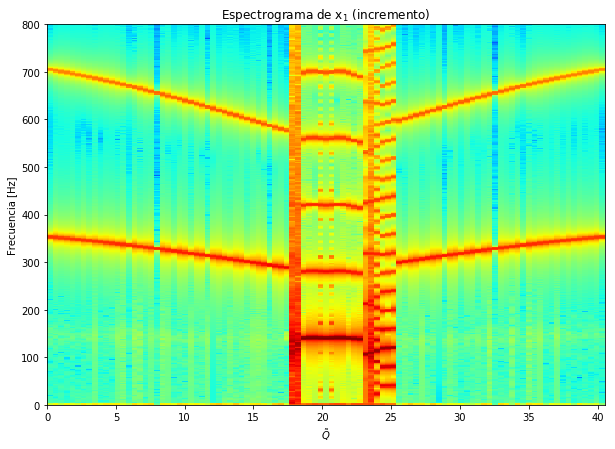

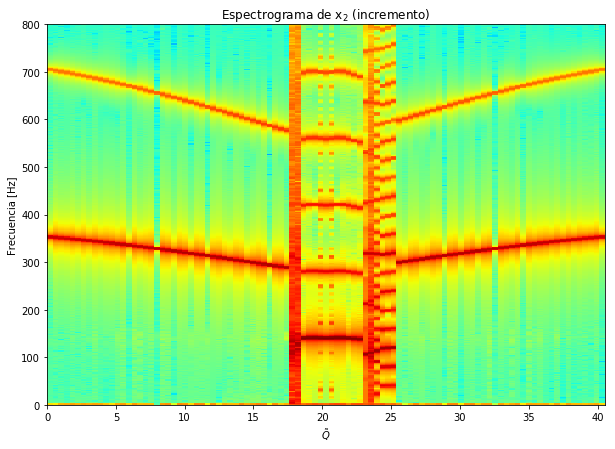

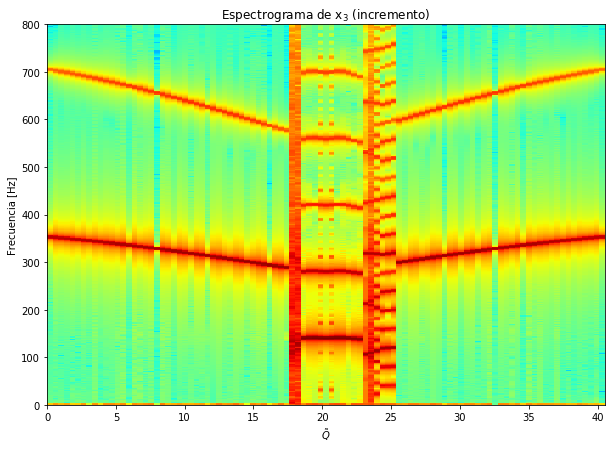

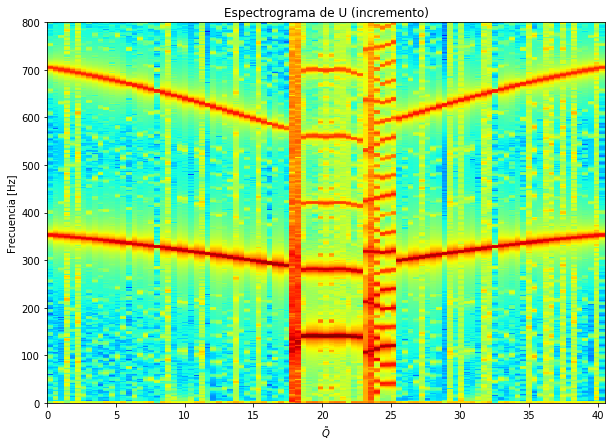

In [8]:
for name in total:
    plt.figure(figsize=(10,7))
    plt.specgram(total[name], NFFT=8192, Fs=rate, noverlap=0, cmap='jet')
    plt.title('Espectrograma de {} (incremento)'.format(name))
    plt.xlabel(r'$\tilde{Q}$')
    plt.ylabel('Frecuencia [Hz]')
    plt.ylim(0, 800)
    plt.show()